## nsCamera tutorial

Copyright &copy; 2025, Lawrence Livermore National Security, LLC.  All rights reserved

LLNL-CODE-838080

This work was produced at the Lawrence Livermore National Laboratory (LLNL) under 
contract no. DE-AC52-07NA27344 (Contract 44) between the U.S. Department of Energy (DOE)
and Lawrence Livermore National Security, LLC (LLNS) for the operation of LLNL.
'nsCamera' is distributed under the terms of the MIT license. All new contributions must
be made under this license.

Author: Jeremy Martin Hill (jerhill@llnl.gov)

Version: 2.1.2  (February 2025)

---

## Welcome to nsCamera!
**nsCamera** is a Python package that provides an interface to the LLNL family of nanosecond-gated CMOS cameras. This document will explain the general operation of the camera and demonstrate the features available in software. This document will create additional files and directories, so it is recommended to copy it to a suitable workspace directory before continuing with the tutorial.

## Getting started

### Installation
The most recent nsCamera software package is available from the LLNL bitbucket server at https://mybitbucket.llnl.gov/projects/NSGCP/repos/camera_python/browse/dist. Please download one of the compressed files and unzip it. Detailed instructions on installation are located in the docs folder (nsCamera-2.x.x/nsCamera/docs/README.pdf). If the code is installed correctly, the following import should silently succeed. If it fails, first be sure that the python instance that nsCamera is installed into is the same as that running this Jupyter session before trying to troubleshoot the installation.

NOTE: code cells in Jupyter (like the one immediately below) may be edited freely. To submit the contents of the entire cell to python, click somewhere inside the cell and type shift-enter. If the result is not immediately available, you will see 'In [\*]' to the left of the box until the command is finished, at which point the asterisk will be replaced with a number. 
Shift-enter can also be used to proceed cell-by-cell through the tutorial, highlighting text boxes and running code boxes.

In [44]:
from nsCamera.CameraAssembler import CameraAssembler
import time
import os
import logging

outputdir = "tutorialoutput"

### Hardware specification
To setup the connection to the camera, you must first specify the specific hardware that is being used. Uncomment the correct option for each hardware parameter
- board: specify version of camera board being used, LLNL_v1 or LLNL_v4
- comm: specify communication protocol used, GigE (ethernet) or RS422
- sensor: specify which sensor is attached to the camera board: icarus, icarus2, or daedalus

In [ ]:
# board = 'LLNL_v1'
board = 'LLNL_v4'

comm = 'GigE'
# comm = 'RS422'

# sensor = 'icarus'
#sensor = 'icarus2'
# sensor = 'icarus'
#sensor = 'icarus2'
sensor = 'daedalus'

### Instantiate the cameraAssembler object
The cameraAssmbler object represents the camera in software, and all commands and data flows are done in the context of that object. Multiple cameras may be controlled simultaneously, with each being addressed through its own cameraAssembler object. The verbose option controls what kinds of messages are reported to the console. 'verbose=4' allows all INFO and higher logging messages to be reported. 'verbose=5' enables the reporting of DEBUG messages, which is usually more details than anyone wants to see. 

If you are running this tutorial on a Linux machine, you may need to use the second version of the command below that specifies the IP address of the camera board.

The Doxygen documentation 'nsCameraDox' for the nsCamera code is available in various formats in */nsCamera/docs/*. Use the search function to look up more information about each function (including options that are not discussed in detail below).

You can initialize the object with the additional optional parameters 'logtag' (which adds object-specific text to error messages) and 'logfile' (which would save the console output to a text file but is not being used for this example)

In [46]:
ca = CameraAssembler(commname=comm, boardname=board, sensorname=sensor, verbose=4, logtag="(1)")
# ca = CameraAssembler(commname=comm, boardname=board, sensorname=sensor, verbose=4, ip='192.168.1.100')

INFO(1): [Daedalus] Initializing sensor object
INFO (1): [GigE] Initializing GigE comms object
INFO (1): [GigE] searching for Orange Tree cards
INFO (1): [GigE] 1 Orange Tree card(s) found
INFO (1): [LLNL_v4] Initializing board object
INFO (1): [LLNL_v4] initBoard LLNLv4
INFO (1): [LLNL_v4] configADCs
INFO (1): [LLNL_v4] initSensor
INFO (1): [CA]resetting timer for power check function
INFO (1): [LLNL_v4] resetTimer
INFO (1): [CA]Python version: 3.12.7
INFO (1): [CA]nsCamera software version: 2.1.2
INFO (1): [CA]FPGA firmware version: 40250117
INFO (1): [CA]FPGA implementation: 84000312
INFO (1): [CA]Board type: LLNLv4
INFO (1): [CA]Rad-Tolerant: True
INFO (1): [CA]Sensor family: Daedalus
INFO (1): [CA]Sensor label: [Daedalus] 
INFO (1): [CA]Available interfaces: RS422, GigE
INFO (1): [CA]GigE connected to 192.168.1.100:20482


You should see a list of messages above, first a sequence of messages about initializing the components of the board and then a list of operating details. 'ca' is the name of the cameraAssembler object, and from this point all commands will be  methods of this object.

### Arm the camera
For the first acquisition, we will just rely on the defaults set when the board is set up. To arm the camera, submit the command *ca.arm* with the appropriate triggering parameter.
- Software triggering: the board can provide its own internal trigger, which is convenient for testing, but provides no control of image timing.
- Hardware triggering: the board waits for a sequence of external triggers to control image acquisition. This is required for precise image timing, but requires additional equipment to generate.

In [29]:
ca.arm('Software');
# ca.arm('Hardware') # only use if you have a external triggering signal ready

INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture


If the camera is using hardware triggering, it is now waiting for a trigger to arrive. If it using a software trigger, it has by now received one. As soon as a trigger is received, the camera acquires an image from the sensor and loads it into the camera's memory. The readoff command waits until the camera reports that the image is available in the camera's memory, then downloads it to the PC. This is very quick for the GigE, but may take a minute or so with RS422.

In [30]:
frames, datalen, data_err = ca.readoff()

INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM


*readoff* returns a tuple
- frames: list of arrays of image data
- datalen: the length of the downloaded data in bytes
- data_err: a flag indicating an error reported in the acquisition process

In [6]:
frames, datalen, data_err

([array([13638, 13855, 13997, ..., 13428, 13456, 13427], dtype=uint16),
  array([14871, 15000, 14686, ..., 14863, 14823, 15019], dtype=uint16),
  array([13785, 13879, 13887, ..., 13907, 13832, 14206], dtype=uint16),
  array([14530, 14387, 14459, ..., 14370, 14103, 14314], dtype=uint16)],
 4194304,
 False)

*readFrames* is similar to *readoff*, but just returns the data.

In [32]:
ca.arm('Software');
# ca.arm('Hardware') # only use if you have a external triggering signal ready
frames = ca.readFrames()

INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM


*plotFrames* plots the images:

INFO (1): [CA]: plotFrames: index = None


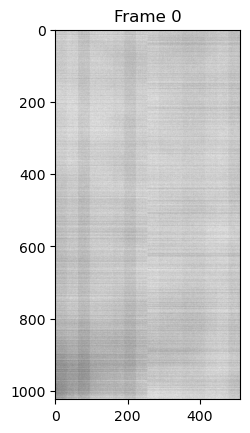

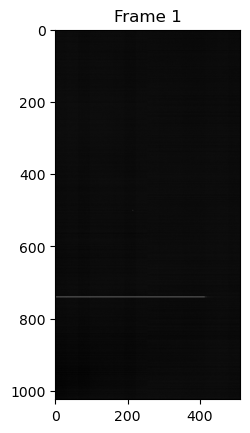

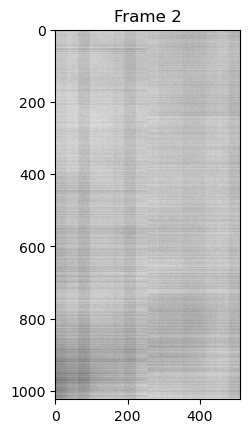

In [33]:
ca.plotFrames(frames);

Congratulations! Unless things have gone awry, you've acquired your first images using nsCamera.

## Camera controls
Now that we've demonstrated a working camera, let's explore the commands that control the specifics of camera operation.

### High-speed shutter timing
The *setTiming* command sets the shutter timing for the sensor. Each sensor has two ('A' and 'B') hemispheres, and their respective timings may be set independently. The tuple indicates the timing (shutter open, shutter closed) in nanoseconds. The *delay* parameter introduces a delay (in nanoseconds) before opening the shutter the first time. 
Because of the way high-speed timing control is implemented in the sensor, some timing patterns cannot be implemented exactly as requested. If this occurs, the software will emit a warning indicating the actual timing that will be generated in the form 

*{delay} \[frame0_open, frame0_closed, frame1_open, ...\]*

The sum (shutter open time + shutter closed time + delay) must not exceed 40 ns per frame.

In [34]:
ca.setTiming('A', (2,3), delay = 0);
ca.setTiming('B', (14,2), delay = 5);

INFO(1): [Daedalus] setTiming; side=A, sequence=(2, 3), delay=0
INFO(1): [Daedalus] HST side A: (2, 3); delay = 0
INFO(1): [Daedalus] setTiming; side=B, sequence=(14, 2), delay=5
INFO(1): [Daedalus] HST side B: (14, 2); delay = 5
INFO(1): [Daedalus] getTiming
INFO(1): [Daedalus] get timing, side B
WARNING(1): [Daedalus] setTiming: Due to sequence length, the actual timing sequence for side B will be {5} [14, 2, 14, 10, 14]


The *getTiming* command queries the board for the high-speed timing setting associated with one hemisphere of the board. If called with the 'actual' flag, it will calculate and return the actual timing that will be generated.

In [35]:
print("Set timing: " + str(ca.getTiming('B')))
print("Actual timing: " + str(ca.getTiming('B', actual = True)))

INFO(1): [Daedalus] getTiming
INFO(1): [Daedalus] get timing, side B
INFO(1): [Daedalus] getTiming
INFO(1): [Daedalus] get timing, side B


Set timing: ('B', 14, 2, 5)
Actual timing: [5, 14, 2, 14, 10, 14]


### Manual shutter timing
The manual timing option permits much longer exposure times than the standard high-speed timing. The open and shut times are multiples of 25 ns, up to approximately 26.8 seconds. *setManualShutters* expects two tuples (for the A and B hemispheres) of times in nanoseconds thus: (frame0_open, frame0_shut, frame1_open, ...). Times given will be rounded down to a multiple of 25 ns (i.e. a setting of '140' will result in an actual timing of 125 ns) with a minimum of 75 ns. The current setting for manual shutters is retrieved using *getManualTiming*.

While 'icarus' and 'icarus2' are physically distinct sensors, the manual timing functionality is the same for both; however, only the two middle images will be available from the icarus sensor.

INFO(1): [Daedalus] Manual shutter sequence: [(100, 150, 200, 250, 300), (100, 500, 1000, 5000, 10000)]
ERROR(1): [Daedalus] Invalid manual shutter timing list: [(100, 150, 200, 250, 300), (100, 500, 1000, 5000, 10000)]; timing settings unchanged


Manual timing: [0, 0, 0, 0, 0]


INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM
INFO (1): [CA]: plotFrames: index = None


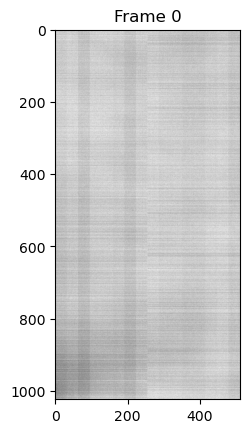

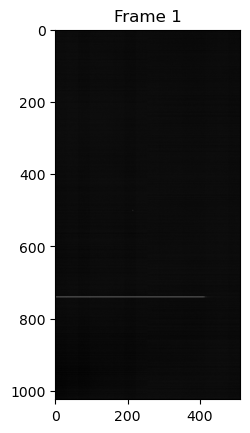

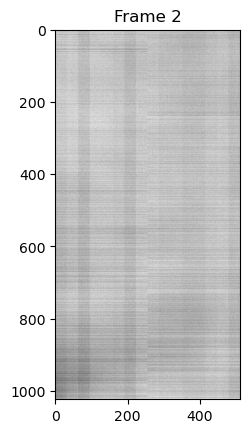

In [36]:
if ca.FPGAsensor == 'Icarus':
    ca.setManualShutters([(100,150,200,250,300,350,400),(100,500,1000,5000,10000,50000,100000)])
else:
    ca.setManualShutters([(100,150,200,250,300),(100,500,1000,5000,10000)])
print("Manual timing: " + str(ca.getManualTiming()))
time.sleep(1)
ca.arm("Software")
manframes, _, _ = ca.readoff();
ca.plotFrames(manframes);


### POT/DAC control and monitoring
Each board has several potentiometers (LLNL_v1) or DACs (LLNL_v4) that are used to provide controlled voltages for sensor operation. The *setPotV* command sets the voltage for a specified pot/DAC. If the *tune* flag is set and a monitor channel is available for that particular pot/DAC, the software will iteratively adjust the setting to make the output voltage match the requested voltage.

In [14]:
ca.setPotV("HST_OSC_CTL", 2.5, tune=True, errflag=True)

('', 'aaaa8029fffff7370000')

The *getMonV* command reads the actual voltage at the named pot. The *getPotV* command is used to retrieve the voltage setting, which is not necessarily the \_actual\_ voltage present nor, if tuning is used, the original setting used in the 'setPotV' command.

In [37]:
print("VRST voltage set to 5 V")
print("\nWithout tuning:")
ca.setPotV('VRST', .5);
print("VRST Voltage setting: " + str(ca.getPotV('VRST')))
print("VRST Voltage reading: " + str(ca.getMonV('VRST')))
print("\nWith tuning:")
ca.setPotV('VRST', .5, tune = True);
print("VRST Voltage setting: " + str(ca.getPotV('VRST')))
print("VRST Voltage reading: " + str(ca.getMonV('VRST')))

VRST voltage set to 5 V

Without tuning:
VRST Voltage setting: 0.5000381475547417
VRST Voltage reading: 0.4996336996336996

With tuning:
VRST Voltage setting: 0.5002670328831922
VRST Voltage reading: 0.5004395604395604


Depending on the specific board, the settings and readings may not match. In any case, without tuning, the *setting* should be close to the requested voltage. With tuning, the *reading* (the actual voltage generated) should be close to the requested voltage. Tuning will set the voltage as close as possible to the requested voltage, but the resolutions of both the pots/DACs and their respective monintors are finite.

### Register / subregister control
Settings and operations on the camera board can be accessed through its register bank. Most interesting features are accessible through the *getSubregister* and *setSubregister* commands. Subregisters are comprised of a subset of bits of a register, but may be accessed by name and independently of the rest of the register. Subregister commands use binary strings and return tuples (error string, response string).

In [38]:
if int(ca.getSubregister('STAT_HSTCONFIGDONE')[1]): # checks status flag for high-speed timing
    print("HST is configured")
else:
    print("HST is not configured")
print("Oscillator option (two bits): " + ca.getSubregister('OSC_SELECT')[1])

HST is configured
Oscillator option (two bits): 00


*getRegister* and *setRegister* works with the entire contents of a 32-bit register. Set a subregister (when available) instead of a whole register to minimize the probability of user error. Register commands use hexadecimal strings and return tuples (error string, response string).

In [39]:
print("On board timer count (hex): " + ca.getRegister('TIMER_VALUE')[1])
ca.setSubregister('RESET_TIMER', '1') # resets on-board timer
print("On board timer count after reset: " + ca.getRegister('TIMER_VALUE')[1])

print("\nChanginging HSTALLWEN waiting period to 500")
ca.setRegister('HSTALLWEN_WAIT_TIME', "000001F4"); # default value is 0x00000190

On board timer count (hex): 0000003a
On board timer count after reset: 00000000

Changinging HSTALLWEN waiting period to 500


### Image saving
Acquired images can be saved to disk using the *saveTiffs* and *saveNumpys* commands. By default, filenames begin with timestamps and end with 'FrameN' where N is the frame number of the image. See the doxygen documentation for details on specifying paths and file names.
- *saveTiffs* saves images to individual tiff files (one per frame)
- *saveNumpys* saves images to individual numpy files (one per frame)

If the PC is unable to download a complete or checked image set, it will automatically dump the contents of the data stream to a single numpy file.

In [40]:
ca.saveTiffs(frames, path=os.path.join(os.getcwd(), outputdir));
time.sleep(1)
ca.saveNumpys(frames, path=os.path.join(os.getcwd(), outputdir), filename="NumpyFrame", 
              prefix=time.strftime("%y%m%d-%H%M%S_", time.localtime()));

INFO (1): [CA]: saveTiffs
INFO (1): [CA]saveNumpys


### Board status
Several functions are available for querying the status of the board. Not all are applicable to every board; invalid requests will safely fail with a warning and a zero result. See the documentation for *reportStatus* in the board files (e.g., nsCamera/boards/LLNL_v4.py) for details as to what report messages are available.

The *printBoardInfo* function is automatically called during initialization of the cameraAssembler, but may be used at any time to report information about the current hardware and software configuration. 

In [41]:
ca.reportStatus()
time.sleep(1)
print("Temperature: " + str(ca.getTemp()));
print("Pressure: " + str(ca.getPressure()));
print("Board timer count in seconds: " + str(ca.getTimer()))
time.sleep(1)
ca.printBoardInfo()

INFO (1): [LLNL_v4] Status report:
INFO(1): [Daedalus] getTiming
INFO(1): [Daedalus] get timing, side A
INFO(1): [Daedalus] getTiming
INFO(1): [Daedalus] get timing, side B
INFO (1): [LLNL_v4] Temperature reading: 39.48 C
INFO (1): [LLNL_v4] Pressure sensor reading: 121.66 mV


INFO (1): [LLNL_v4] Sensor read complete
INFO (1): [LLNL_v4] Coarse trigger detected
INFO (1): [LLNL_v4] Fine trigger detected
INFO (1): [LLNL_v4] Sensor readout in progress
INFO (1): [LLNL_v4] Sensor readout complete
INFO (1): [LLNL_v4] SRAM readout started
INFO (1): [LLNL_v4] SRAM readout complete
INFO (1): [LLNL_v4] High-speed timing configuration started
INFO (1): [LLNL_v4] All ADCs configured
INFO (1): [LLNL_v4] All DACs configured
INFO (1): [LLNL_v4] Timer has reset
INFO (1): [LLNL_v4] High-speed timing configuration complete
INFO(1): [Daedalus] RSLNALLWENB detected
INFO(1): [Daedalus] RSLNALLWENA detected
INFO(1): [Daedalus] High-speed timing: A:[0, 2, 3, 2, 3, 2], B:[5, 14, 2, 14, 10, 14]


INFO (1): [LLNL_v4] getTimer


Temperature: 39.523992673992666
Pressure: 840.5569022868972
Board timer count in seconds: 10


INFO (1): [CA]Python version: 3.12.7
INFO (1): [CA]nsCamera software version: 2.1.2
INFO (1): [CA]FPGA firmware version: 40250117
INFO (1): [CA]FPGA implementation: 84000312
INFO (1): [CA]Board type: LLNLv4
INFO (1): [CA]Rad-Tolerant: True
INFO (1): [CA]Sensor family: Daedalus
INFO (1): [CA]Sensor label: [Daedalus] 
INFO (1): [CA]Available interfaces: RS422, GigE
INFO (1): [CA]GigE connected to 192.168.1.100:20482


In [20]:
ca.getPressure()

745.9431808731775

### Reduced read-off options

#### setFrames
The *setFrames(first, last)* function allows the user to reset the range of images to be read off of the sensor. The frames will be read off from *first* to *last*, inclusive. (i.e., *setFrames(0,3)* would set the board to read all four images from an Icarus2.)

Calling *setFrames* without parameters resets the frame readoff to all available frames.

INFO (1): [CA]Readoff set to 1 frame (1, 1)
INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM
INFO (1): [CA]: plotFrames: index = None


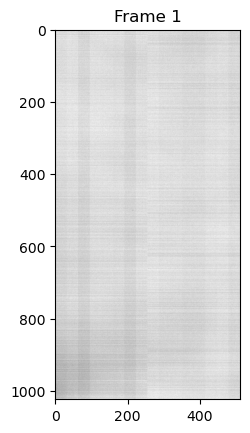

INFO (1): [CA]Readoff set to 3 frames (0, 2)


In [42]:
ca.setFrames(1,1) # read off just frame 1
ca.arm("Software")
limitedframes, _, _ = ca.readoff();
ca.plotFrames(limitedframes);
time.sleep(1)
ca.setFrames();

#### setRows

The *setRows(first, last)* function allows the user to reset the range of rows from each image to be read off of the sensor. The rows will be read off from *first* to *last*, inclusive. (i.e., *setRows(0,1023)* would set the board to acquire the entire image.)

The additional flag *fullsize* will cause the software to generate full size images with the collected rows in their proper location and the rest filled with zeroes.

Calling *setRows* without parameters resets the image readoff to full size.

INFO (1): [CA]Readoff set to 1 frame (1, 1)
INFO (1): [CA]Readoff set to 450 rows (450, 899)
INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM
INFO (1): [CA]: plotFrames: index = None


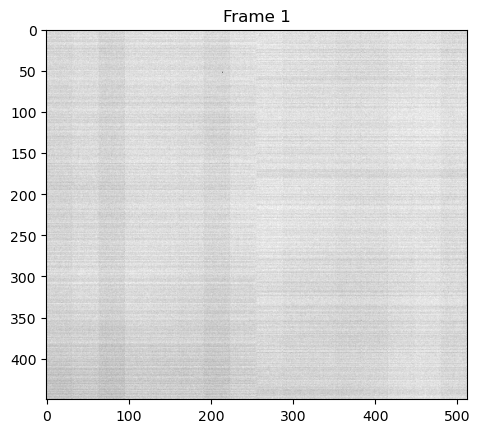

INFO (1): [CA]Readoff set to 450 rows (450, 899)
INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM
INFO (1): [CA]: plotFrames: index = None


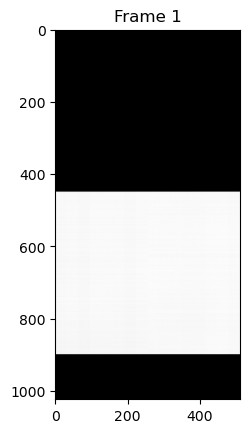

INFO (1): [CA]Readoff set to 1024 rows (0, 1023)
INFO (1): [CA]Readoff set to 3 frames (0, 2)


''

In [43]:
ca.setFrames(1,1)
ca.setRows(450,899)
ca.arm("Software")
rowsframes, _, _ = ca.readoff();
ca.plotFrames(rowsframes);
ca.setRows(450,899, padToFull=True)
ca.arm("Software")
rowsframes, _, _ = ca.readoff();
ca.plotFrames(rowsframes);
ca.setRows()
ca.setFrames()

## Daedalus features
The following sections concern features unique to the Daedalus sensor. 

### Interlacing
Interlacing increases the number of images acquired by delaying the timing sequence for rows in an interlaced pattern. For example, *setInterlacing(1)* interlaces one row; that is, it divides the sensor grid into even and odd rows. Images are first acquired using the even rows only, then the timing sequence is repeated for the odd rows. An interlacing factor of _n_ generates *n+1* times as many images, each shorter by that same factor of *n+1*. Change the argument to *setInterlacing* in the following code to see its effect.

Turning on interlacing automatically deactivates High Full Well mode and Zero Dead Time mode. The default no-interlacing mode can be restored by calling *setInterlacing(0)*.

INFO(1): [Daedalus] Interlacing set to [1, 1]
INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM
INFO (1): [CA]: plotFrames: index = None


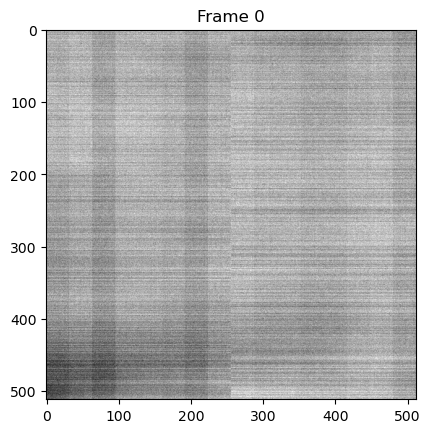

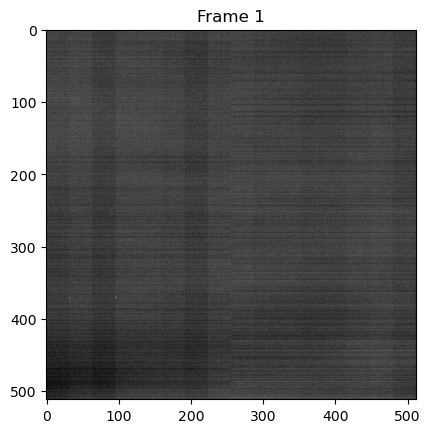

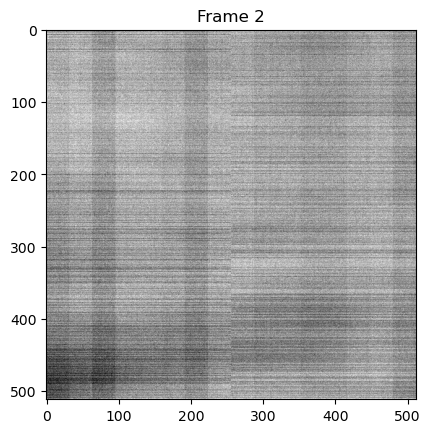

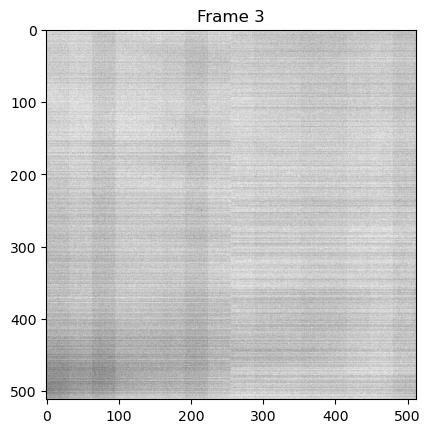

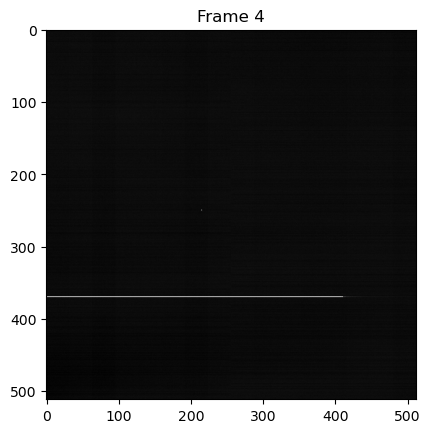

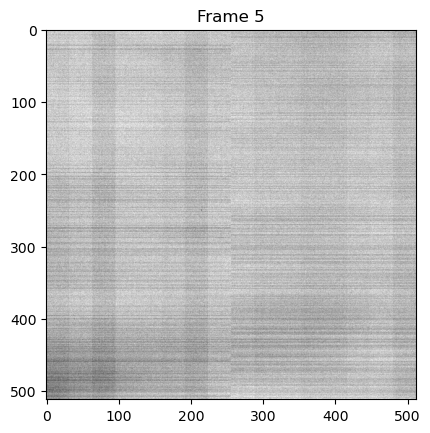

INFO(1): [Daedalus] Interlacing set to [0, 0]


In [47]:
if ca.FPGAsensor == 'Daedalus':
    ca.setInterlacing(1)
    ca.arm("Software")
    interframes, _, _ = ca.readoff();
    ca.plotFrames(interframes);
    ca.setInterlacing(0)
else:
    print("Sorry, this example only applies to daedalus sensors")

### High Full Well mode
In High Full Well mode, all frames are acquired simultaneously. *setHighFullWell(True)* activates HFW mode, 'False' deactivates it.

Turning on HFW mode automatically deactivates Zero Dead Time mode and interlacing. Deactivating HFW mode returns the board to the default uninterlaced mode.

INFO(1): [Daedalus] Interlacing set to [0, 0]
INFO(1): [Daedalus] High Full Well mode active
INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM
INFO (1): [CA]: plotFrames: index = None


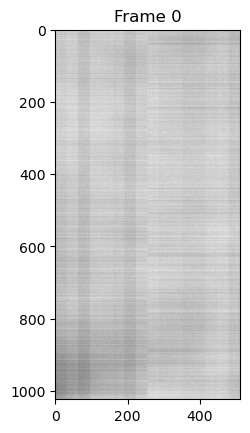

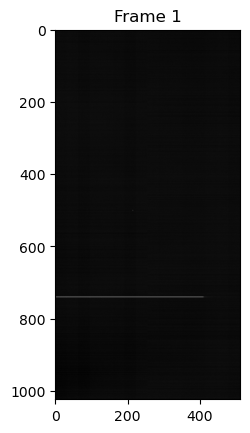

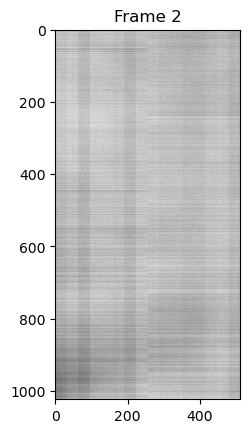

INFO(1): [Daedalus] High Full Well mode inactivate


In [48]:
if ca.FPGAsensor == 'Daedalus':
    ca.setHighFullWell(True)
    ca.arm("Software")
    interframes, _, _ = ca.readoff();
    ca.plotFrames(interframes);
    ca.setHighFullWell(False)
else:
    print("Sorry, this example only applies to daedalus sensors")

### Zero Dead Time mode
In Zero Dead Time mode, the sensor is singly interlaced. The even rows are timed as usual, but the odd rows invert the pattern and are open when the even rows close and vice-versa. For example, with a 5,3 timing mode, the even side has a {delay}-open/close timing of __{0}-5/3-5/3-5__ while the odd side has the timing __{5}-3/5-3/5-3__

*setZeroDeadTime(True)* activates HFW mode, 'False' deactivates it.

Turning on ZDT mode automatically deactivates High Full Well mode and interlacing. Deactivating ZDT mode returns the board to the default uninterlaced mode.

In [ ]:
if ca.FPGAsensor == 'Daedalus':
    ca.setZeroDeadTime(True)
    ca.arm("Software")
    interframes, _, _ = ca.readoff();
    ca.plotFrames(interframes);
    ca.setZeroDeadTime(False)
else:
    print("Sorry, this example only applies to daedalus sensors")

INFO(1): [Daedalus] Zero Dead Time mode active; actual interlacing = 1
INFO (1): [LLNL_v4] latchPots
INFO (1): [LLNL_v4] startCapture
INFO (1): [GigE] readoff
INFO (1): [LLNL_v4] waitForSRAM, timeout = 0
INFO (1): [LLNL_v4] SRAM ready
INFO (1): [LLNL_v4] readSRAM


## Advanced features

### Higher performance options
Under normal circumstances while using the GigE connection, nsCamera is capable of acquiring full image sets (multiple frames at 512x1024) at about 1 Hz. This may not be sufficient for some applications, however, so a couple of higher-performance options are available.
#### Batch readoff
Batch readoff acquires a finite set of images very quickly. Once acquisition is complete, the acquired data is processed and images are saved. This is the fastest method, however, it requires all acquired data to be stored in memory, so there is a limit (depending on the host RAM) to how many images can be acquired in a single batch.The *showProgress* option prints progressive comments every 10 (in this case) sets; if this option is omitted, the function prints nothing until the acquisition and saving is complete.

In [23]:
iterations = 10
timeElapsed = ca.batchAcquire(iterations, 'Software',path=os.path.join(os.getcwd(), outputdir), filename="Frame")
print("Batch readoff required " + str(timeElapsed) + " seconds for " + str(iterations) + " iterations.")

INFO(1): [CA] batchAcquire: temporarily disabling warning and information logging 
INFO(1): [CA] batchAcquire: re-enabling logging


Batch readoff required 3.659989833831787 seconds for 10 iterations.


#### Fast readoff
If the option 'fast=True' is used in the readoff command, the nsCamera software bypasses the numerical processing of the data from the camera and returns the raw data string. This string can be saved using the saveFrames method, which will save the string to disk as a text file. The resulting file can be opened at any later time using the loadDumpedData() method. This converts the file contents to frames, which can be directly used by saveTiffs, plotFrames, etc.
This method is slightly slower than batchReadoff, but has the advantage of being restricted by disk space instead of RAM.

Note: in practice, you probably want to disable information logging during this process because the logging process slows everything down; the commands commented-out in the example below (lines 1 and 6) set the verbosity to 2 (errors only) temporarily, then set it back to its previous level once the acquisitions are complete.

In [24]:
# logging.getLogger().setLevel(ca.verbmap.get(2))
ca.arm('Software')
textframes, datalen, data_err = ca.readoff(waitOnSRAM=True, fast=True)
print("Acquisition complete")
ca.saveFrames(textframes, path=os.path.join(os.getcwd(), outputdir), prefix='')
# logging.getLogger().setLevel(ca.verblevel)
print("File saved")

INFO(1): [LLNL_v4] latchPots
INFO(1): [LLNL_v4] startCapture
INFO(1): [GigE] readoff
INFO(1): [LLNL_v4] waitForSRAM, timeout = 0
INFO(1): [LLNL_v4] SRAM ready
INFO(1): [LLNL_v4] readSRAM
INFO(1): [CA] saveFrames


Acquisition complete
File saved


To process saved acquisitions, it is not necessary to have an instantiated cameraAssembler object. Import the required modules from nsCamera.utils.misc and use the loadDumpedData function. If the data is acquired using the default sensor parameters, then only the sensor name needs to be provided to the function.

If non-default parameters are used (e.g., setRows() is used to change the image size), then the relevant parameters must be passed to the function. The full function signature is:

**loadDumpedData**(*filename, path, filetype, sensor, firstframe, lastframe, width, height, padToFull, firstrow, lastrow, maxwidth, maxheight, interlacing*).

For convenience, you can use the tuple output of loadDumpedData() directly:
    
    frametuple=loadDumpedData(sensor=sensor,path=outputdir,filename='frames.txt')
    plotFrames(frametuple)
    saveTiffs(frametuple)

You can also load numpy files saved using saveNumpys using the loadDumpedData function.

INFO: [Icarus2] Initializing sensor object
INFO: [FS] : plotFrames: index = None


File loaded


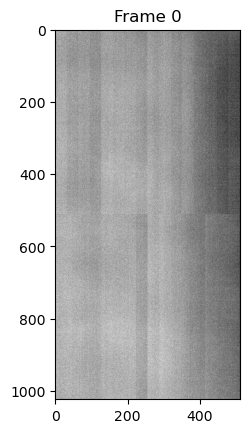

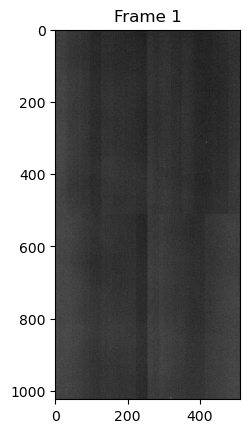

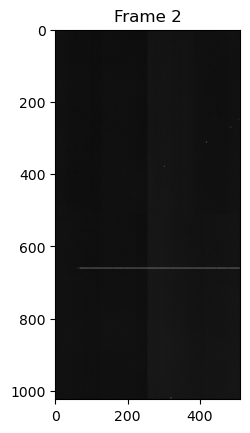

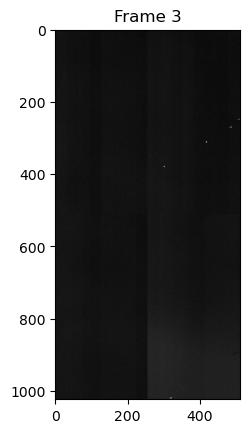

INFO: [FS] : saveTiffs


File saved


In [23]:
from nsCamera.utils.misc import loadDumpedData, saveTiffs, plotFrames
parameters, frames = loadDumpedData(sensor=sensor,path=outputdir, filename='frames.txt')
print("File loaded")
plotFrames(parameters,frames)
saveTiffs(parameters, frames)
print("File saved")

### Arbitrary high-speed timing
The *setArbTiming* command allows a unique duration to be defined for each shutter open and close. Timing is defined in the list \[delay, frame0_open, frame0_closed, frame1_open, ... \] NOTE: the first number is the initial delay.
Extra parameters are ignored. 
- For Icarus2, [1,2,3,4,5,6,7,8] should generate the timing __{1}-2/3-4/5-6/7-8__
- Icarus will use the same timing scheme, but since only the two middle frames are used, the resulting image timing should be __{6}-4/5-6__ (including the 'delay' from the skipped frame 0); to optimize flexibility, use the sequence [0,1,1,X,Y,Z,1,1]
to implement frame 1 open for X ns, shutter closed for Y ns, and frame 2 open for Z ns.
- Daedalus will only generate three frames worth: __{1}-2/3-4/5-6__

In [ ]:
if ca.FPGAsensor == 'Icarus':
    ca.setArbTiming('A', [1,2,3,4,5,6,7,8]);
else:
    ca.setArbTiming('A', [1,2,3,4,5,6]);

print("Arbitrary timing: " + str(ca.getTiming("A", actual=True)))

INFO(1): [Icarus] HST side A (arbitrary): [1, 2, 3, 4, 5, 6, 7, 8]
INFO(1): [Icarus] get timing, side A
WARNING(1): [Icarus] Due to use of the Icarus model 1 sensor, the actual timing sequence for side A will be {6} [4, 5, 6]


### Power monitoring
The *powerCheck* function checks to see if board power has been maintained since initialization of the cameraAssembler object or since the last time *initPowerCheck* was called. 'False' means that power has been interrupted.

In [27]:
if ca.powerCheck():
    print("Power has not failed since CA initialization or last call of initPowerCheck()")
else:
    print("Power has failed since CA initialization or last call of initPowerCheck()")
time.sleep(1)
ca.initPowerCheck()

INFO(1): [LLNL_v4] getTimer


Power has not failed since CA initialization or last call of initPowerCheck()


INFO(1): [CA] resetting timer for power check function
INFO(1): [LLNL_v4] resetTimer


### Software Coarse trigger
A single coarse trigger can be triggered from the software to ready the board for a hardware trigger

In [29]:
# ca.arm() # uncomment only if hardware fine triggering is available
# ca.setSubregister('SW_COARSE_TRIGGER','1')
# frames, _, _ = ca.readoff();
# ca.plotFrames(frames);

## Disconnect from the board
After working with the board, use the close function to make sure that all connections are properly closed

In [30]:
ca.closeDevice()

---
Copyright &copy; 2025, Lawrence Livermore National Security, LLC.  All rights reserved.

LLNL-CODE-838080

This work was produced at the Lawrence Livermore National Laboratory (LLNL) under
contract no. DE-AC52-07NA27344 (Contract 44) between the U.S. Department of Energy
(DOE) and Lawrence Livermore National Security, LLC (LLNS) for the operation of LLNL.
'nsCamera' is distributed under the terms of the MIT license. All new
contributions must be made under this license.